In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

## Считываем данные

In [3]:
prices = pd.read_excel('~/notebooks/summer_school/data/price.xlsx', index_col=0, parse_dates=True)
index = pd.read_excel('~/notebooks/summer_school/data/benchmark.xlsx', index_col=0, parse_dates=True)['CLOSE']

pe = pd.read_excel('~/notebooks/summer_school/data/mults/pe.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('~/notebooks/summer_school/data/financials/market_cap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('~/notebooks/summer_school/data/liquidity/volume.xlsx', index_col=0, parse_dates=True)

In [4]:
# корректируем матрицы (сортировка + удаление лишних колонок и индексов)
prices, pe, mcap, volume = pqr.correct_matrices(prices, pe, mcap, volume)

## Создаем на основе данных факторы

In [5]:
# фильтр на основе среднедневного объема
liquidity_filter = pqr.Factor(volume).look_back().data > 2_000_000

# основной фактор на основе P/E
value = pqr.Factor(pe).transform(looking_back_period=3, lag_period=0, holding_period=3)
value.prefilter(liquidity_filter)

# взвешивающий фактор на основе капитализации
size_w = pqr.Factor(mcap).look_back()

# бенчмарк уже готовый
benchmark = pqr.Benchmark('FTSE MIB').from_index(index)

## "Обучаем" факторную модель.

In [6]:
portfolios = pqr.fit_factor_model(
    stock_prices=prices,
    factor=value,
    weighting_factor=size_w,
    fee_rate=0.0005,
    balance=100_000,
    quantiles=3,
    add_wml=True,
    is_bigger_better=True
)

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/pqr/portfolios.py:278: RuntimeWarning: invalid value encountered in floor_divide
  portfolio.values[0] * balance // stock_prices.values[0])
/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/pqr/portfolios.py:289: RuntimeWarning: invalid value encountered in floor_divide
  alloc = w * cur_balance // prices
/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/pqr/portfolios.py:278: RuntimeWarning: invalid value encountered in floor_divide
  portfolio.values[0] * balance // stock_prices.values[0])
/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/pqr/portfolios.py:289: RuntimeWarning: invalid value encountered in floor_divide
  alloc = w * cur_balance // prices
/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/pqr/portfolios.py:278: RuntimeWarning: invalid value encountered in floor_divide
  portfolio.values[0] * balance // stock_prices.values[0])
/home/akbabkin/n

## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [7]:
portfolios[0].returns

2016-04-30    0.000000
2016-05-31   -0.070253
2016-06-30   -0.204869
2016-07-31    0.147263
2016-08-31   -0.017745
                ...   
2020-12-31   -0.011484
2021-01-31   -0.035844
2021-02-28    0.159705
2021-03-31    0.110709
2021-04-30   -0.005102
Name: q(0.00, 0.33), Length: 61, dtype: float64

In [8]:
pqr.alpha(portfolios[0], benchmark)

-0.0021900977926689476

In [9]:
pqr.rolling_alpha(portfolios[0], benchmark)

2016-04-30         NaN
2016-05-31         NaN
2016-06-30         NaN
2016-07-31         NaN
2016-08-31         NaN
                ...   
2020-12-31   -0.013633
2021-01-31   -0.009301
2021-02-28   -0.003099
2021-03-31   -0.019661
2021-04-30   -0.009115
Freq: M, Length: 61, dtype: float64

In [10]:
pqr.rolling_sharpe_ratio(portfolios[0])

2016-04-30         NaN
2016-05-31         NaN
2016-06-30         NaN
2016-07-31         NaN
2016-08-31         NaN
                ...   
2020-12-31   -0.315945
2021-01-31   -0.254796
2021-02-28    0.189332
2021-03-31    0.989043
2021-04-30    1.057747
Length: 61, dtype: float64

In [11]:
pqr.max_drawdown(portfolios[0])

-0.44323590594308493

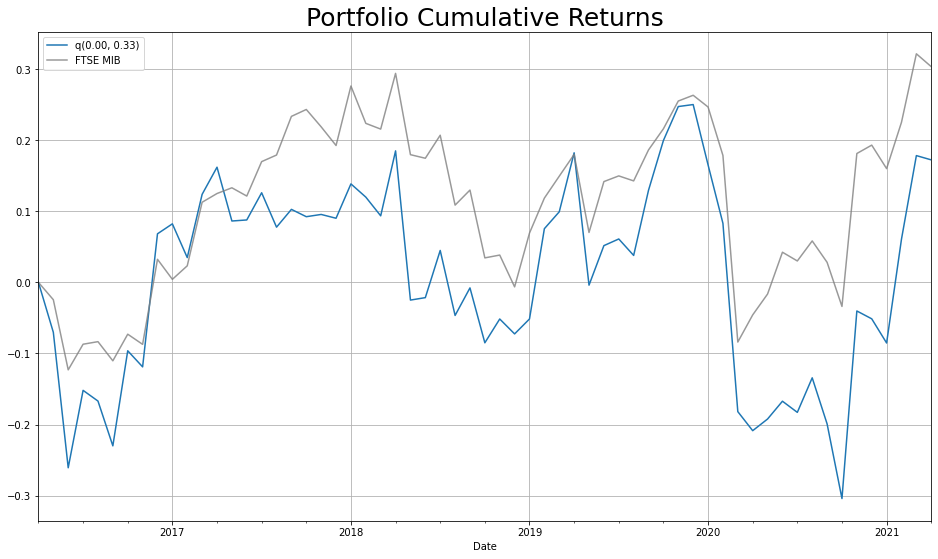

In [12]:
pqr.plot_cumulative_returns(portfolios[0], benchmark=benchmark)

## Сравниваем портфели 
tabulate пришлось убрать, поскольку при отрисовке больше 3 портфелей у меня слетало форматирование из-за того, что вывод не помещался. Пока временно сделал табличку с помощью пандаса

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)",wml
"Alpha, %",-0.22,0.15,-0.41,-0.19
Beta,1.41,0.96,0.94,-0.47
Sharpe Ratio,0.26,0.41,0.11,-0.25
"Mean Return, %",0.72,0.79,0.22,-0.50
"Volatility, %",9.80,6.62,7.05,7.03
"Mean Excess Return, %",0.05,0.12,-0.45,-1.17
Benchmark Correlation,0.89,0.90,0.83,-0.41
"Win Rate, %",52.46,60.66,50.82,45.90
"Maximum Drawdown, %",-44.32,-34.99,-27.84,-44.42


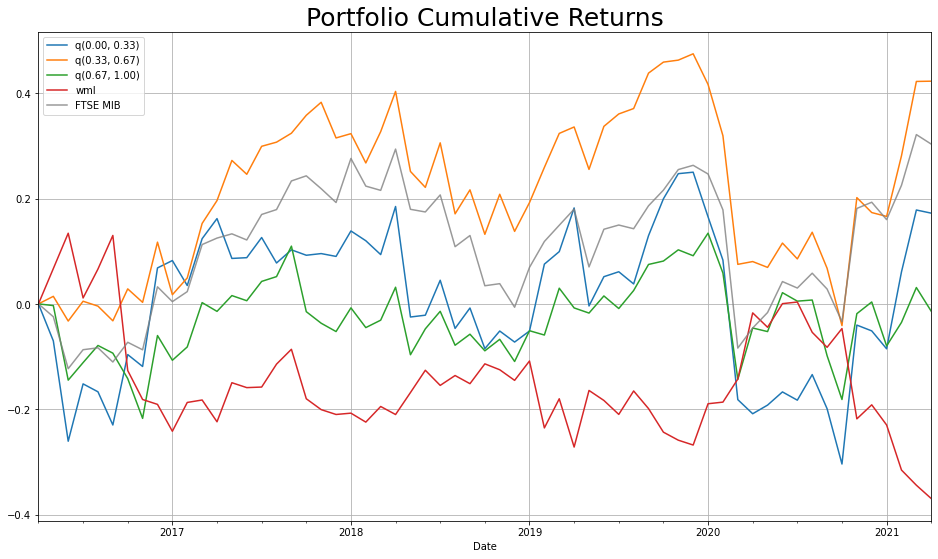

In [13]:
pqr.factor_model_tear_sheet(
    *portfolios,
    benchmark=benchmark
)

## grid_search
Функция из модуля factor_model - принимает на вход сначала 3 списка/массива/чего угодно, по чему можно итерироваться; дальше все параметры повторяют параметры метода fit(). Возвращает словарь, в котором ключ - кортеж вида (1, 0, 1) - это, соответственно, looking_period, lag_period, holding_period, а значение - датафрейм с результатами (такой же, как и в compare_portfolios()). 

In [14]:
%%time
%%capture

results = pqr.grid_search(
    prices,
    pe,
    looking_back_periods=[1, 3, 6, 9, 12],
    method='static',
    lag_periods=[0, 1],
    holding_periods=[1, 3, 6, 9, 12],
    balance=100_000,
    mask=liquidity_filter,
    weighting_factor=size_w,
    benchmark=benchmark
)

CPU times: user 3.58 s, sys: 18.5 ms, total: 3.6 s
Wall time: 3.6 s


In [15]:
results[(1, 0, 1)]

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)"
"Alpha, %",-0.50,0.35,-0.33
Beta,1.49,0.82,0.98
Sharpe Ratio,0.14,0.49,0.13
"Mean Return, %",0.40,0.84,0.26
"Volatility, %",10.15,6.00,7.05
"Mean Excess Return, %",-0.21,0.24,-0.35
Benchmark Correlation,0.90,0.84,0.85
"Win Rate, %",47.62,57.14,47.62
"Maximum Drawdown, %",-48.85,-27.11,-31.68


In [16]:
results[(12, 0, 12)]

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)"
"Alpha, %",-0.25,0.25,-0.00
Beta,1.29,0.96,0.93
Sharpe Ratio,0.23,0.45,0.29
"Mean Return, %",0.58,0.87,0.59
"Volatility, %",8.79,6.69,7.01
"Mean Excess Return, %",-0.06,0.22,-0.05
Benchmark Correlation,0.91,0.89,0.83
"Win Rate, %",55.77,61.54,46.15
"Maximum Drawdown, %",-45.87,-36.45,-27.47


# zero_intelligence_test

In [17]:
best_portfolio = portfolios[2]

In [18]:
%%time
%%capture

target_values, random_portfolios = pqr.zero_intelligence_test(
    prices, 
    best_portfolio, 
    pqr.sharpe_ratio, 
    n=1000, 
    quantiles=5
)

CPU times: user 6.65 s, sys: 19.1 ms, total: 6.67 s
Wall time: 6.67 s


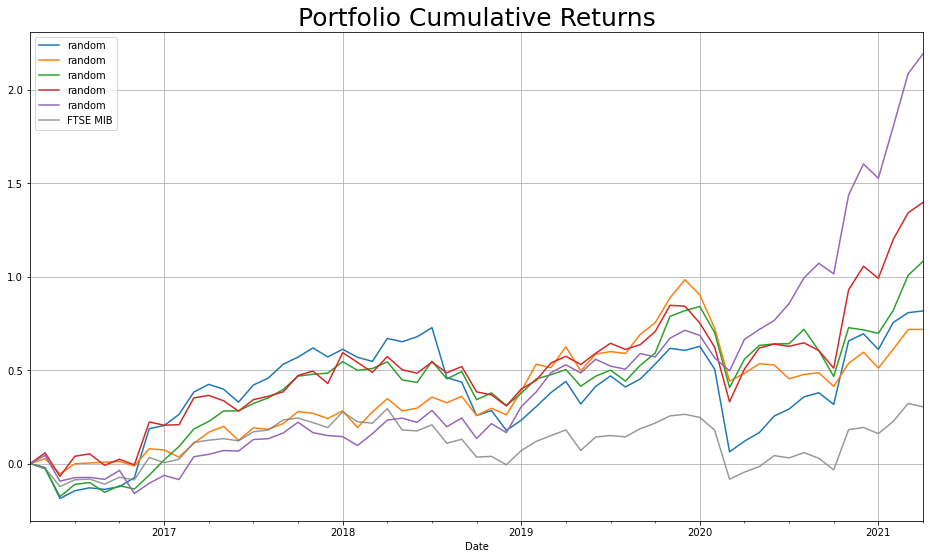

In [19]:
pqr.plot_cumulative_returns(
    *random_portfolios,
    benchmark=benchmark
)